In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [179]:
#Define the number of elememts in each set I, J, K
i_num = 10
k_num = 3
j_num = 100 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [197]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i0', 'i1',
       'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9'],
      dtype='object', name='Point number')

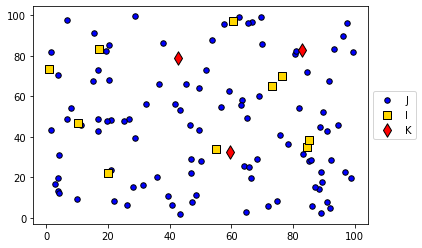

In [181]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [182]:
#Define constants

B = 100
S = 50
alpha = 10
beta = 400
q_j = {j: 50 for j in J.index}
mu = 10

Deterministic model

In [183]:
theta_det = {}
for n in range(0, len(list(I.index))):
    theta_det[I.index[n]] = list(poisson.rvs(mu, size = 1))[0]
theta_det

{'i0': 6,
 'i1': 12,
 'i2': 11,
 'i3': 12,
 'i4': 7,
 'i5': 12,
 'i6': 9,
 'i7': 12,
 'i8': 10,
 'i9': 6}

In [184]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 57.432456916451,
 ('k0', 'j1'): 38.12592196655708,
 ('k0', 'j2'): 35.83229152273128,
 ('k0', 'j3'): 16.04911420141311,
 ('k0', 'j4'): 37.51863542561215,
 ('k0', 'j5'): 58.85948359414988,
 ('k0', 'j6'): 77.0622917565394,
 ('k0', 'j7'): 65.88307211355584,
 ('k0', 'j8'): 66.29112279340275,
 ('k0', 'j9'): 34.08419593946731,
 ('k0', 'j10'): 53.91284624808822,
 ('k0', 'j11'): 14.152533849809359,
 ('k0', 'j12'): 61.31521480154823,
 ('k0', 'j13'): 85.07968251233663,
 ('k0', 'j14'): 85.70282543125403,
 ('k0', 'j15'): 63.4831680761129,
 ('k0', 'j16'): 77.46029108472288,
 ('k0', 'j17'): 59.37443820584747,
 ('k0', 'j18'): 76.95671401671201,
 ('k0', 'j19'): 67.63730734114124,
 ('k0', 'j20'): 55.22212580922614,
 ('k0', 'j21'): 32.08894122045787,
 ('k0', 'j22'): 29.439880211203302,
 ('k0', 'j23'): 68.13328439206492,
 ('k0', 'j24'): 41.825210367552245,
 ('k0', 'j25'): 28.579517696770186,
 ('k0', 'j26'): 60.178316859895645,
 ('k0', 'j27'): 56.678880107849686,
 ('k0', 'j28'): 57.524609158

In [185]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j9'),
 ('k0', 'j11'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j34'),
 ('k0', 'j37'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j54'),
 ('k0', 'j56'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j63'),
 ('k0', 'j65'),
 ('k0', 'j66'),
 ('k0', 'j68'),
 ('k0', 'j72'),
 ('k0', 'j73'),
 ('k0', 'j75'),
 ('k0', 'j76'),
 ('k0', 'j77'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j85'),
 ('k0', 'j86'),
 ('k0', 'j89'),
 ('k0', 'j90'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j95'),
 ('k0', 'j96'),
 ('k0', 'j97'),
 ('k0', 'j99'),
 ('k0', 'k0'),
 ('k0', 'k1'),
 ('k0', 'k2'),
 ('k1', 'j2'),
 ('k1', 'j3'),
 ('k1', 'j4'),
 ('k1', 'j5'),
 ('k1', 'j7'),
 ('k1', 'j8'),
 ('k1', 'j9'),
 ('k1', 'j10'),
 ('k1', 'j11'),
 ('k1', 'j13'),
 ('k1', 'j14'),
 ('k1', 'j15'),
 ('k1',

In [186]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []
  
M_kj  

{('k0', 'j1'): ['i3', 'i5', 'i7'],
 ('k0', 'j2'): ['i1'],
 ('k0', 'j3'): ['i1', 'i3', 'i5', 'i7', 'i9'],
 ('k0', 'j4'): ['i2', 'i9'],
 ('k0', 'j9'): ['i2', 'i9'],
 ('k0', 'j11'): ['i1', 'i2', 'i3', 'i5', 'i7', 'i8', 'i9'],
 ('k0', 'j21'): ['i3', 'i5', 'i7'],
 ('k0', 'j22'): ['i3', 'i5', 'i7'],
 ('k0', 'j24'): [],
 ('k0', 'j25'): ['i3', 'i5', 'i7'],
 ('k0', 'j30'): ['i5', 'i7'],
 ('k0', 'j31'): ['i3', 'i5', 'i7'],
 ('k0', 'j32'): ['i9'],
 ('k0', 'j34'): ['i2'],
 ('k0', 'j37'): ['i1', 'i3'],
 ('k0', 'j41'): ['i1', 'i3', 'i5', 'i7'],
 ('k0', 'j42'): ['i3', 'i5'],
 ('k0', 'j48'): ['i1', 'i2', 'i3', 'i5', 'i7', 'i9'],
 ('k0', 'j49'): ['i7', 'i8', 'i9'],
 ('k0', 'j50'): ['i7', 'i8', 'i9'],
 ('k0', 'j54'): ['i8', 'i9'],
 ('k0', 'j56'): ['i2', 'i8', 'i9'],
 ('k0', 'j59'): ['i2', 'i9'],
 ('k0', 'j60'): ['i8', 'i9'],
 ('k0', 'j63'): ['i3', 'i5', 'i7', 'i9'],
 ('k0', 'j65'): ['i7', 'i9'],
 ('k0', 'j66'): ['i2', 'i8', 'i9'],
 ('k0', 'j68'): ['i2', 'i8', 'i9'],
 ('k0', 'j72'): ['i3', 'i5', 'i7'],
 

In [187]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i

{'i0': [('k1', 'j2'),
  ('k1', 'j7'),
  ('k1', 'j8'),
  ('k1', 'j10'),
  ('k1', 'j13'),
  ('k1', 'j14'),
  ('k1', 'j15'),
  ('k1', 'j16'),
  ('k1', 'j18'),
  ('k1', 'j19'),
  ('k1', 'j20'),
  ('k1', 'j21'),
  ('k1', 'j22'),
  ('k1', 'j26'),
  ('k1', 'j27'),
  ('k1', 'j28'),
  ('k1', 'j33'),
  ('k1', 'j35'),
  ('k1', 'j36'),
  ('k1', 'j37'),
  ('k1', 'j38'),
  ('k1', 'j39'),
  ('k1', 'j41'),
  ('k1', 'j45'),
  ('k1', 'j47'),
  ('k1', 'j52'),
  ('k1', 'j55'),
  ('k1', 'j58'),
  ('k1', 'j71'),
  ('k1', 'j74'),
  ('k1', 'j77'),
  ('k1', 'j79'),
  ('k1', 'j80'),
  ('k1', 'j82'),
  ('k1', 'j83'),
  ('k1', 'j84'),
  ('k1', 'j85'),
  ('k1', 'j86'),
  ('k1', 'j88'),
  ('k1', 'j94'),
  ('k1', 'j98'),
  ('k1', 'k1'),
  ('k2', 'j1'),
  ('k2', 'j10'),
  ('k2', 'j26'),
  ('k2', 'j42'),
  ('k2', 'j53'),
  ('k2', 'j55'),
  ('k2', 'j72'),
  ('k2', 'j82'),
  ('k2', 'k2')],
 'i1': [('k0', 'j2'),
  ('k0', 'j3'),
  ('k0', 'j11'),
  ('k0', 'j37'),
  ('k0', 'j41'),
  ('k0', 'j48'),
  ('k0', 'j76'),
  ('k0', 

In [188]:
model_det = gp.Model('Location-allocation problem 1')

In [189]:
x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [190]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I.index), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in L), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j3', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j4', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j9', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j9', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i1'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i3'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i5'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i7'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i8'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j11', 'i9'): <gurobi.Constr *Awaiting Model Update*>,
 

In [191]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + beta * gp.quicksum(y_j), GRB.MINIMIZE)

In [192]:
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 353 rows, 1673 columns and 1279 nonzeros
Model fingerprint: 0x971ca65d
Variable types: 0 continuous, 1673 integer (103 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e+00, 1e+02]
Found heuristic solution: objective 4970.0000000
Presolve removed 194 rows and 1109 columns
Presolve time: 0.00s
Presolved: 159 rows, 564 columns, 1085 nonzeros
Variable types: 0 continuous, 564 integer (96 binary)

Root relaxation: objective 1.343096e+03, 357 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

  

In [193]:
nSolutions = model_det.SolCount
print('Number of solutions found: ' + str(nSolutions))
for iter2 in range(nSolutions):
        model_det.setParam(GRB.Param.SolutionNumber, iter2)
        print('%g ' % model_det.PoolObjVal, end='\n')
        for v in model_det.getVars():
             if v.xn > 0:
                   print ('%s %g' % (v.varName, v.Xn))
        print("\n")
print("\n")

Number of solutions found: 5
1770 
x_ikj[i0,k1,j37] 6
x_ikj[i1,k0,j37] 12
x_ikj[i2,k0,k0] 11
x_ikj[i3,k1,j37] 12
x_ikj[i4,k1,j37] 7
x_ikj[i5,k1,j37] 12
x_ikj[i6,k1,j37] 9
x_ikj[i7,k2,k0] 12
x_ikj[i8,k0,k0] 10
x_ikj[i9,k0,k0] 6
y_j[j37] 1
y_j[k0] 1


2170 
x_ikj[i0,k1,j77] 6
x_ikj[i1,k1,j77] 12
x_ikj[i2,k0,k0] 11
x_ikj[i3,k1,j77] 12
x_ikj[i4,k1,j77] 7
x_ikj[i5,k1,j77] 12
x_ikj[i6,k1,j37] 9
x_ikj[i7,k2,j77] 12
x_ikj[i8,k0,k0] 10
x_ikj[i9,k0,j77] 6
y_j[j37] 1
y_j[j77] 1
y_j[k0] 1


2570 
x_ikj[i0,k1,j77] 6
x_ikj[i1,k1,j77] 12
x_ikj[i2,k0,j48] 11
x_ikj[i3,k1,j48] 12
x_ikj[i4,k1,j77] 7
x_ikj[i5,k2,j48] 12
x_ikj[i6,k1,j37] 9
x_ikj[i7,k0,j77] 12
x_ikj[i8,k0,k0] 10
x_ikj[i9,k0,j77] 6
y_j[j37] 1
y_j[j48] 1
y_j[j77] 1
y_j[k0] 1


3370 
x_ikj[i0,k1,j77] 6
x_ikj[i1,k0,j2] 1
x_ikj[i1,k0,j37] 4
x_ikj[i1,k0,j77] 4
x_ikj[i1,k1,j77] 3
x_ikj[i2,k0,j48] 11
x_ikj[i3,k0,j1] 1
x_ikj[i3,k1,j48] 5
x_ikj[i3,k2,j77] 6
x_ikj[i4,k1,j77] 7
x_ikj[i5,k0,j1] 1
x_ikj[i5,k2,j48] 4
x_ikj[i5,k2,k0] 7
x_ikj[i6,k1,j37] 9
x

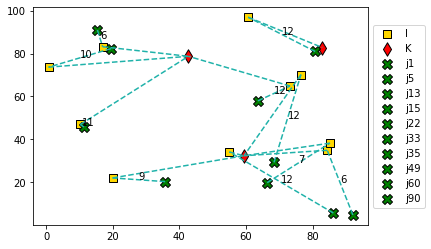

In [194]:
# plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
#             marker = 'o', s = 30, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 50, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 90, label = 'K')


for v in model_det.getVars():
    if v.xn > 0:
        if v.varName.startswith('x_ikj'):
            indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
            plt.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                     (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                     color = 'lightseagreen', linestyle = "--")
            plt.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                     (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                     color = 'lightseagreen', linestyle = "--")
            plt.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                               (J.loc[indices_x[2], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
        else:
            index_y = v.varName[4:-1]
            plt.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
        
            

plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

Probabilistic model

In [195]:
theta_ran = poisson(mu) #create a Poisson distributed random variable
theta_ran

In [196]:
for v in model_det.getVars():
    if v.xn > 0:
        print(v.VarName, v.xn)

x_ikj[i0,k1,j33] 6.0
x_ikj[i1,k1,j13] 12.0
x_ikj[i2,k0,j90] 11.0
x_ikj[i3,k0,j22] 12.0
x_ikj[i4,k1,j15] 7.0
x_ikj[i5,k1,j35] 12.0
x_ikj[i6,k1,j5] 9.0
x_ikj[i7,k2,j1] 12.0
x_ikj[i8,k0,j49] 10.0
x_ikj[i9,k0,j60] 6.0
y_j[j1] 1.0
y_j[j5] 1.0
y_j[j13] 1.0
y_j[j15] 1.0
y_j[j22] 1.0
y_j[j33] 1.0
y_j[j35] 1.0
y_j[j49] 1.0
y_j[j60] 1.0
y_j[j90] 1.0
